In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

<ipython-input-1-4addd0ae159c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 33% 5.00M/15.1M [00:00<00:00, 41.3MB/s]
100% 15.1M/15.1M [00:00<00:00, 83.8MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
  os.chdir('/content/yes')
X = []
y = []
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      X.append(img)
      y.append((i[0:1]))
      print(i[0:1])
os.chdir('/content/no')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      X.append(img)
for i in range(1,99):
    y.append('N')
print(y)

NameError: ignored

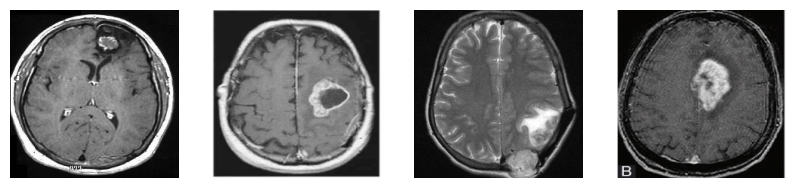

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [ ]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (169, 224, 224, 3)
X_test Shape:  (84, 224, 224, 3)
y_train Shape:  (169, 2)
y_test Shape:  (84, 2)


In [ ]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

58889256/58889256 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
6/6 [==============================] - 175s 31s/step - loss: 7.7609 - accuracy: 0.5444 - val_loss: 1.2508 - val_accuracy: 0.6071
Epoch 2/5
6/6 [==============================] - 180s 31s/step - loss: 0.8085 - accuracy: 0.6568 - val_loss: 1.2541 - val_accuracy: 0.6071
Epoch 3/5
6/6 [==============================] - 173s 31s/step - loss: 0.6755 - accuracy: 0.7337 - val_loss: 0.6642 - val_accuracy: 0.6786
Epoch 4/5
6/6 [==============================] - 173s 31s/step - loss: 0.4074 - accuracy: 0.8047 - val_loss: 0.4908 - val_accuracy: 0.8571
Epoch 5/5
6/6 [==============================] - 177s 32s/step - loss: 0.3038 - accuracy: 0.8757 - val_loss: 0.4010 - val_accuracy: 0.8452


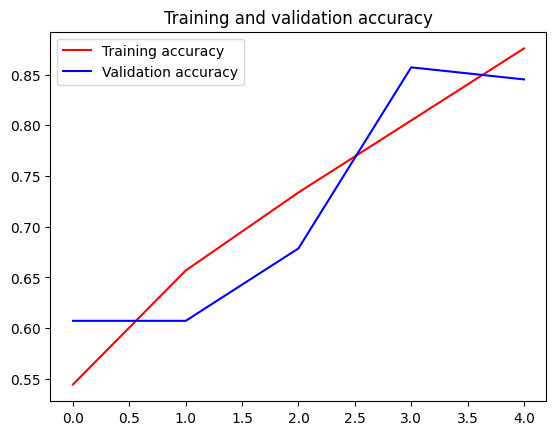

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
import cv2

# Load and preprocess the input image
image = cv2.imread("/content/brain_tumor_dataset/yes/Y10.jpg")
if image is None:
    print("Error: Could not load image")
else:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Find contours in the thresholded image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if len(contours) > 0:
        print("Tumor present")
    else:
        print("Tumor not present")


Tumor present
